In [1]:
import mindquantum.core.gates as Gate
import numpy as np                                          
from mindquantum.core.circuit import Circuit                
from mindquantum.core.gates import H, RX, RY, RZ,X    
from mindquantum.core.parameterresolver import PRGenerator  
from mindquantum.simulator import Simulator
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split   
from mindquantum.algorithm.library import amplitude_encoder
from mindquantum.algorithm.nisq import HardwareEfficientAnsatz     
from mindquantum.core.operators import QubitOperator           # 导入QubitOperator模块，用于构造泡利算符
from mindquantum.core.operators import Hamiltonian             # 导入Hamiltonian模块，用于构建哈密顿量
import mindspore as ms                                                                         # 导入mindspore库并简写为ms
from mindquantum.framework import MQLayer,MQN2Layer                                              # 导入MQLayer
# 导入HardwareEfficientAnsatz
from mindquantum.core.gates import RY           
import torch
from torchvision import datasets, transforms# 导入量子门RY
from scipy.ndimage import zoom
import random

/opt/miniconda3/envs/MindSpore/lib/python3.9/site-packages/mindquantum/simulator/__init__.py:17: UserWarning: Unable import mqvector gpu backend due to: cannot import name '_mq_vector_gpu' from partially initialized module 'mindquantum' (most likely due to a circular import) (/opt/miniconda3/envs/MindSpore/lib/python3.9/site-packages/mindquantum/__init__.py)
  from .available_simulator import SUPPORTED_SIMULATOR


In [21]:
# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor()
])
np.random.seed(10)
def filter_3_and_6(data):
    images, labels = data
    mask = (labels == 3) | (labels == 6)
    return images[mask], labels[mask]


def filter_4_and_7(data):
    images, labels = data
    mask = (labels == 4) | (labels == 7)
    return images[mask], labels[mask]

# 下载和加载 MNIST 数据集
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
filtered_data = filter_4_and_7((mnist_dataset.data, mnist_dataset.targets))
X_data, y = filtered_data  # X 图像数据 y 标签

# 分别对标签为 3 和 6 的数据进行随机抽样
def sample_data(X, y, label, sample_ratio=0.2):
    label_mask = (y == label)
    X_label = X[label_mask]
    y_label = y[label_mask]
    
    sample_size = int(len(y_label) * sample_ratio)
    sample_indices = np.random.choice(len(y_label), sample_size, replace=False)
    
    return X_label[sample_indices], y_label[sample_indices]

X_data_4, y_data_4 = sample_data(X_data, y, label=4, sample_ratio=0.1)
X_data_7, y_data_7 = sample_data(X_data, y, label=7, sample_ratio=0.1)
print(X_data_4.shape, y_data_4.shape)

# 合并抽样后的数据
X_sampled = torch.cat((X_data_4, X_data_7), dim=0)
y_sampled = torch.cat((y_data_4, y_data_7), dim=0)

zoom_factor = 16 / 28
Compressed_X = np.array([zoom(img,zoom_factor) for img in X_sampled])
Compressed_X = Compressed_X/255
# Compressed_X = torch.tensor(Compressed_X, dtype=torch.float32)

print(Compressed_X.shape, y_sampled.shape)


torch.Size([584, 28, 28]) torch.Size([584])
(1210, 16, 16) torch.Size([1210])


In [19]:
filtered_data[0].shape

torch.Size([12107, 28, 28])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(Compressed_X, y_sampled, test_size=0.2, random_state=0, shuffle=True) # 将数据集划分为训练集和测试集
y_train[y_train==4]=1
y_train[y_train==7]=0
y_test[y_test==4]=1
y_test[y_test==7]=0
print(X_train.shape)                                                                                   # 打印训练集中样本的数据类型
print(X_test.shape)                                                                                    # 打印测试集中样本的数据类型

(968, 16, 16)
(242, 16, 16)


In [30]:
def amplitude_param(pixels):
    param_rd = []
    _, parameterResolver = amplitude_encoder(pixels, 8)   
    for _, param in parameterResolver.items():
        param_rd.append(param)
    param_rd = np.array(param_rd)
    return param_rd

trian_params = [amplitude_param(pixels=i.flatten()) for i in X_train]
test_params  = [amplitude_param(pixels=i.flatten()) for i in X_test]

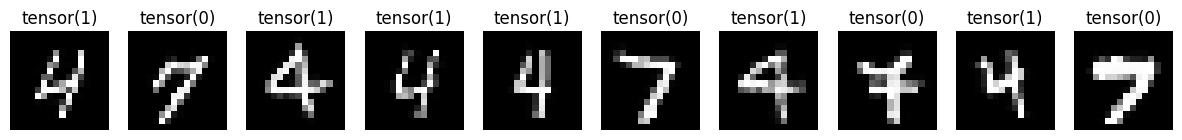

In [25]:
num_images = 10
fig, axes = plt.subplots(1, num_images, figsize=(15, 15))

for i in range(num_images):
    axes[i].imshow(X_train[i], cmap='gray')
    axes[i].set_title(y_train[i])
    axes[i].axis('off')  # 隐藏坐标轴

plt.show()

In [26]:
def Classifying_circuit(qubit_num, block_num, Ent_circ):
    num = qubit_num
    depth = block_num
    circ = Circuit()
    for i in range(depth):
        circ = Para_circuit(circ, num)
        if Ent_circ == 'Ent1':
            circ = Ent1_circuit(circ, num)
        elif Ent_circ == 'Ent2':
            circ = Ent2_circuit(circ, num)
        elif Ent_circ == 'Ent3':
            circ = Ent3_circuit(circ, num)
    return circ

def Ent1_circuit(circuit,qubit_num):
    for i in range(0,qubit_num-1,2):
        circuit += Gate.Z.on(i+1,i)
    for i in range(1,qubit_num-2,2):
        circuit += Gate.Z.on(i+1,i)
    return circuit

def Ent2_circuit(circuit,qubit_num):
    for i in range(0,qubit_num-1,2):
        circuit += Gate.X.on(i+1,i)
    for i in range(1,qubit_num-2,2):
        circuit += Gate.X.on(i+1,i)
    return circuit

def Ent3_circuit(circuit,qubit_num):
    circuit = Ent2_circuit(circuit,qubit_num)
    circuit = Ent2_circuit(circuit,qubit_num)
    return circuit

def Para_circuit(circuit,qubit_num):
    for i in range(qubit_num):
        circuit += Gate.RX(f'Xtheta{i}').on(i)
        circuit += Gate.RZ(f'Ztheta{i}').on(i)
        circuit += Gate.RX(f'Xtheta2{i}').on(i)
    return circuit

In [27]:
QUBIT_NUM = 8
BLOCK_NUM = 2
Ent = 'Ent3'
ansatz = Classifying_circuit(QUBIT_NUM,BLOCK_NUM,Ent).as_ansatz()

In [31]:
# prg = PRGenerator('alpha')
# encoder = Circuit()
encoder, parameterResolver  = amplitude_encoder(X_train[0].flatten(),8)
encoder = encoder.as_encoder()
encoder = encoder.no_grad()
# ansatz = HardwareEfficientAnsatz(6, single_rot_gate_seq=[RY], entangle_gate=X, depth=3).circuit     # 通过
hams = [Hamiltonian(QubitOperator(f'Z{i}')) for i in [5,6]]

ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")
ms.set_seed(2)                                                     # 设置生成随机数的种子
circuit = encoder+ ansatz.as_ansatz()         
sim = Simulator('mqvector', 8)
grad_ops = sim.get_expectation_with_grad(hams,
                                         circuit,
                                         parallel_worker=5)
QuantumNet = MQLayer(grad_ops)          # 搭建量子神经网络

In [34]:
from mindspore.nn import SoftmaxCrossEntropyWithLogits                         # 导入SoftmaxCrossEntropyWithLogits模块，用于定义损失函数
from mindspore.nn import Adam                                                  # 导入Adam模块用于定义优化参数
from mindspore.train import Accuracy, Model, LossMonitor                       # 导入Accuracy模块，用于评估预测准确率
import mindspore as ms
from mindspore.dataset import NumpySlicesDataset
from torch.utils.data import DataLoader# 导入NumpySlicesDataset模块，用于创建模型可以识别的数据集



loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')            # 通过SoftmaxCrossEntropyWithLogits定义损失函数，sparse=True表示指定标签使用稀疏格式，reduction='mean'表示损失函数的降维方法为求平均值
opti = Adam(QuantumNet.trainable_params(), learning_rate=0.05)                  # 通过Adam优化器优化Ansatz中的参数，需要优化的是Quantumnet中可训练的参数，学习率设为0.1

model = Model(QuantumNet, loss, opti, metrics={'Acc': Accuracy()})             # 建立模型：将MindSpore Quantum构建的量子机器学习层和MindSpore的算子组合，构成一张更大的机器学习网络


train_loader = NumpySlicesDataset({'features': trian_params, 'labels': y_train}, shuffle=False).batch(20) # 通过NumpySlicesDataset创建训练样本的数据集，shuffle=False表示不打乱数据，batch(5)表示训练集每批次样本点有5个
test_loader = NumpySlicesDataset({'features': test_params, 'labels': y_test}).batch(20)                   # 通过NumpySlicesDataset创建测试样本的数据集，batch(5)表示测试集每批次样本点有5个


class StepAcc(ms.Callback):                                                      # 定义一个关于每一步准确率的回调函数
    def __init__(self, model, test_loader):
        self.model = model
        self.test_loader = test_loader
        self.acc = []

    def on_train_step_end(self, run_context):
        
        self.acc.append(self.model.eval(self.test_loader, dataset_sink_mode=False)['Acc'])
        # print(f'ACC = {self.acc[-1]}')


monitor = LossMonitor(100)                                                       # 监控训练中的损失，每16步打印一次损失值

acc = StepAcc(model, test_loader)                                               # 使用建立的模型和测试样本计算预测的准确率

model.train(10, train_loader, callbacks=[monitor, acc], dataset_sink_mode=False)# 将上述建立好的模型训练20次

epoch: 3 step: 2, loss is 0.6488592028617859
epoch: 5 step: 4, loss is 0.6038774251937866
epoch: 7 step: 6, loss is 0.6030932664871216
epoch: 9 step: 8, loss is 0.6239852905273438


Text(0, 0.5, 'Accuracy')

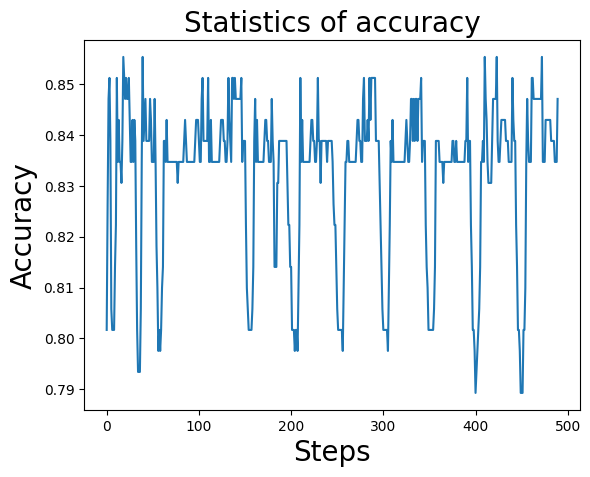

In [35]:
plt.plot(acc.acc)
plt.title('Statistics of accuracy', fontsize=20)
plt.xlabel('Steps', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)